In [1]:
## Python imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os

## respic imports
from rsrespic.fields import fields
from rsrespic.particles import particles 
from rsrespic.solvers import solvers
from rsrespic.utilities import utilities, constants, diagnostics

## lattice import for respic 
from respic_fodo import fodo_cell


## constants 
from scipy.constants import c as c_mks
from scipy.constants import elementary_charge as q_mks 
from scipy.constants import m_p as m_p_mks

q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']
pi = np.pi
c_mks = c / 100.


# Warning! This code requires elegant, sddstools, and is only implemented for protons

* This generates a fodo lattice 
* (10D Q 2D Q 10D Q 2D Q 10D) where D is "drift_length"


In [2]:
## Global parameters for the simulation, energy is kinetic, drift length is in meters

E = 2.0e6
mc2 = m_p_mks * c_mks**2 / q_mks
bgz = np.sqrt((E / mc2 + 1) ** 2. - 1.)
drift_length = 0.2


In [3]:
## Setup fodo lattice for elegant
with open('elegant_fodo_lattice/fodo_lattice_lte.txt', 'r') as file : filedata = file.read()
filedata = filedata.replace('drift_length', str(drift_length))
with open('elegant_fodo_lattice/fodo_lattice.lte', 'w') as file: file.write(filedata)

## Setup input file for elegant 
p_central = bgz
beta_x = 50
alpha_x = 0
emit_x = 1.0e-5
beta_y = 50
alpha_y = 0
emit_y = 1.0e-5

parameter_names = ['p_central_param', 'beta_x_param', 'alpha_x_param', 
                   'beta_y_param', 'alpha_y_param', 'emit_x_param', 'emit_y_param']

parameter_values = [p_central, beta_x, alpha_x, beta_y, alpha_y, emit_x, emit_y]

with open('elegant_fodo_lattice/fodo_lattice_ele.txt', 'r') as file : filedata = file.read()
for i in range(0, len(parameter_names)):
    filedata = filedata.replace(parameter_names[i], str(parameter_values[i]))
with open('elegant_fodo_lattice/fodo_lattice.ele', 'w') as file: file.write(filedata)

## Run elegant
p = subprocess.Popen(['elegant', 'fodo_lattice.ele'], cwd='elegant_fodo_lattice/')
p.wait()


0

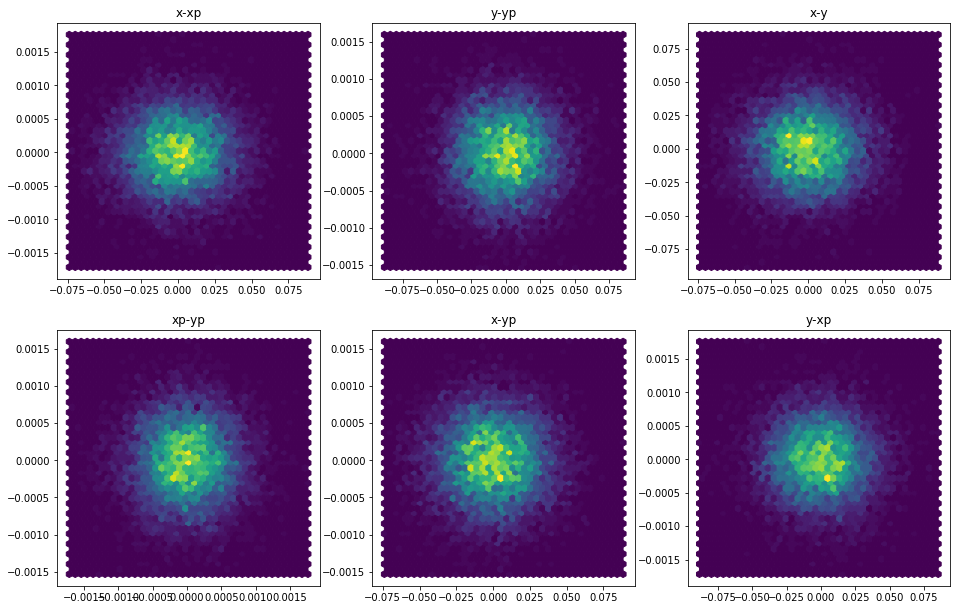

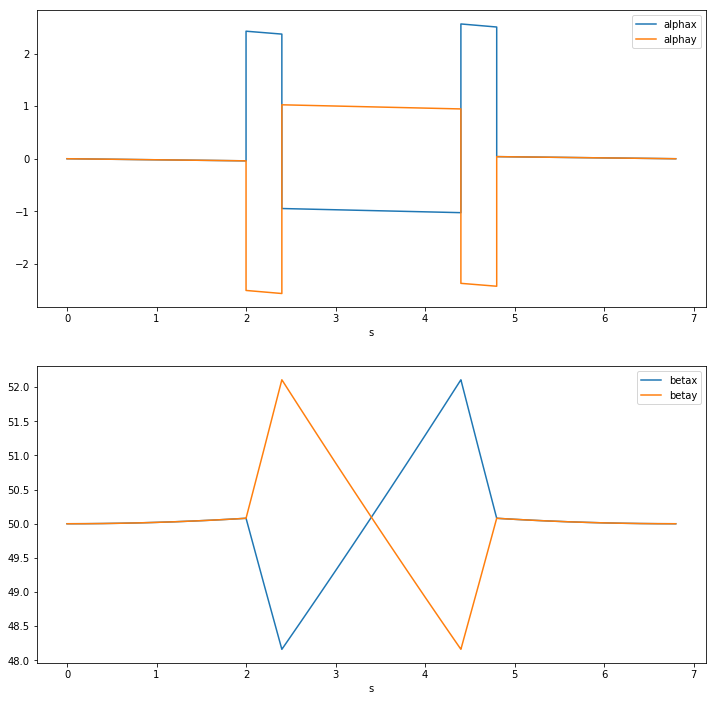

In [4]:
## Verify the solution for elegant

## Read beam from elegant to generate distribution for respic
fn = 'elegant_fodo_lattice/matched_fodo_lattice.bun'
column_names = ['x', 'xp', 'y', 'yp']
dist = utilities.read_sdds_columns(fn, column_names)
utilities.plot_elegant_beam(dist)

## generate beam for respic
beam = np.column_stack([dist.x, dist.xp, dist.y, dist.yp])
np.savetxt('elegant_distribution.txt', beam, delimiter = ',')

## Read matching solution from elegant for plotting
fn_beam_sig = 'elegant_fodo_lattice/matched_fodo_lattice.sig'
column_names = ['s', 'betaxBeam', 'alphaxBeam', 'betayBeam', 'alphayBeam', 'Sx', 'Sy', 'Sxp', 'Syp']
beam_twiss = utilities.read_sdds_columns(fn_beam_sig, column_names)
utilities.plot_twiss_sdds(beam_twiss, flag = 'Beam')


## Read quad strengths from elegant
f = open('elegant_fodo_lattice/fodo_lattice.fit', 'r')
table = [line.strip().split(',') for line in f ]
f.close()
k_list = []
for i in range(0,len(table)):
    if 'QUAD' in table[i][0]:
        line = table[i]
        k_list.append(float(line[-1].strip('K1=')))

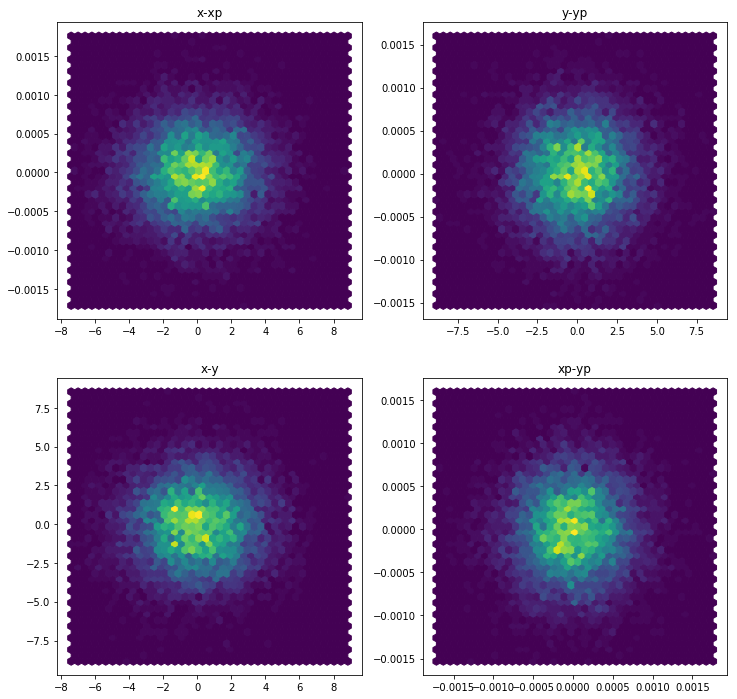

In [11]:
## Setup respic simulation 
charge_per_cm_mks = 1.0e-15  # Charge per cm (make sure to not set to zero because of particle weights)
Q = constants.charge_mks_to_cgs(charge_per_cm_mks)
n_particles = 10000
s = 0

## Load the distribution from elegant
distribution = particles.distribution()
distribution.import_from_file(fn = 'elegant_distribution.txt')

respic_beam = particles.particles_2D_delta(distribution, bunch_charge = Q,
                                            species_mass = m_p, K_e = E)


## Define the fields
sigma_x = np.std(respic_beam.x)
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 10. ## minimum wavelength to resolve

my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
    L_x_min = L_min, L_y_min = L_min)


## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()
my_fields.register_solver(field_solver)


## Diagnostic setup
respic_diag = diagnostics.bunch_statistics()

## Load the maps
maps = solvers.symplectic_maps()

utilities.plot_rspic_beam(respic_beam)

## Construct the lattice using the fodo cell defined in the geometry file
k_array = np.asarray(k_list) * respic_beam.pz / 1000. / 10.

lattice = fodo_cell(L = drift_length, k_array = k_array)

In [12]:
## Setup the number of passes and the initial pass number
turn_number = 0
turns = 1

## Update the diagnostics at the beginning of the simulatoin
respic_diag.update(s, respic_beam)

## Run the simluation 
while turn_number < turns:

    s = lattice.one_turn_map(maps, my_fields, respic_beam, respic_diag, s)
            
    print 'turn_number: ',turn_number
        
    turn_number += 1
    

turn_number:  0


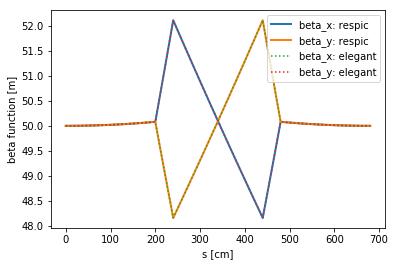

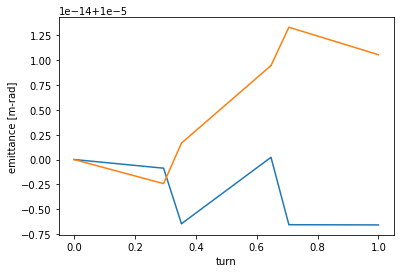

In [13]:
## Plot the result of respic and elegant for zero-current fodo cell
x_key = 's'

plt.figure()
respic_diag.plot(x_key, 'beta_x')
respic_diag.plot(x_key, 'beta_y')
plt.plot(beam_twiss.s * 100, beam_twiss.betaxBeam ,':')
plt.plot(beam_twiss.s * 100, beam_twiss.betayBeam ,':')
plt.xlabel(x_key + ' [cm]')
plt.ylabel('beta function [m]')
plt.legend(['beta_x: respic', 'beta_y: respic', 'beta_x: elegant', 'beta_y: elegant'])


turns = respic_diag.get_parameter('s') / (beam_twiss.s[-1] * 100.)
plt.figure()
plt.plot(turns, respic_diag.get_parameter('ex_rms'))
plt.plot(turns, respic_diag.get_parameter('ey_rms'))
plt.xlabel('turn')
plt.ylabel('emittance [m-rad]')
plt.savefig('emittance.pdf')
plt.show()


